[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MDIL-SNU/sevennet_tutorial/blob/main/CMSS_DFT_2025/Part1_From_scratch/1_From_scratch.ipynb)

#Installation

SevenNet can be easily installed via pip.

In [1]:
!pip install sevenn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
Reason for being yanked: sevenn command fault
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.0/448.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
  

Check whether your installation is successful

In [1]:
from sevenn.logger import Logger
logger = Logger(screen=True)
logger.greeting()

SevenNet: Scalable EquiVariance-Enabled Neural Network
version 0.11.2, Thu Jun 26 11:17:12 2025

                ****
              ********                                   .
              *//////,  ..                               .            ,*.
               ,,***.         ..                        ,          ********.                                  ./,
             .      .                ..   /////.       .,       . */////////                               /////////.
        .&@&/        .                  .(((((((..     /           *//////*.  ...                         *((((((((((.
     @@@@@@@@@@*    @@@@@@@@@@  @@@@@    *((@@@@@     (     %@@@@@@@@@@  .@@@@@@     ..@@@@.   @@@@@@*    .(@@@@@(((*
    @@@@@.          @@@@         @@@@@ .   @@@@@      #     %@@@@         @@@@@@@@     @@@@(,  @@@@@@@@.    @@@@@(*.
    %@@@@@@@&       @@@@@@@@@@    @@@@@   @@@@@      #  ., .%@@@@@@@@@    @@@@@@@@@@   @@@@,   @@@@@@@@@@   @@@@@
    ,(%@@@@@@@@@    @@@@@@@@@@     @@@@@ @@@@&   

# Training from scratch

In [2]:
#### If your session crashed, restart from here ####

import os.path as osp
prefix = 'sevennet_tutorial/CMSS_DFT_2025/'

if not osp.exists(prefix):
  !git clone https://github.com/MDIL-SNU/sevennet_tutorial.git
  print("Done")

In [3]:
# [OPTIONAL] for reproducibility
def set_all_seeds(seed):
    import torch
    import numpy as np
    import random
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 120 # You can change the seed value.
set_all_seeds(SEED)

In [4]:
from ase.io import read
from ase.visualize import view
atoms = read(f'{prefix}/data/600K.extxyz')
view(atoms, viewer='x3d')

In [5]:
from sevenn.train.graph_dataset import SevenNetGraphDataset
from torch_geometric.loader import DataLoader

cutoff = 5.0  # in Angstrom unit.

data_paths = [f'{prefix}/data/600K.extxyz', f'{prefix}/data/1200K.extxyz']
# SevenNetGraphDataset will preprocess atomic structures into graphs (edge determined by cutoff)
dataset = SevenNetGraphDataset(
    cutoff=cutoff, files=data_paths, drop_info=False
)

num_dataset = len(dataset)
num_train = int(num_dataset * 0.95)
num_valid = num_dataset - num_train

dataset = dataset.shuffle()
trainset = dataset[:num_train]
validset = dataset[num_train:]

train_loader = DataLoader(trainset, batch_size=8, shuffle=True)
valid_loader = DataLoader(validset, batch_size=8)

In [6]:
# Let's have a look at processed dataset

print(f"# graphs (structures): {len(trainset)}")
print(f"# nodes (atoms): {trainset.natoms}")

print("Data sample:")
graph = trainset[0]
print(graph)
print(f"DFT label (energy): {graph.total_energy}")
print(f"DFT label (stress): {graph.stress}")
print(f"Force label shape: {graph.force_of_atoms.shape}")

print("\nBatch sample:")
batch = next(iter(train_loader))  # 8 graph = 1 batch
print(batch)
print(f"DFT labels (energy): {batch.total_energy}")
print(f"Force label shape: {batch.force_of_atoms.shape}")
print(f"Stress label shape: {batch.stress.shape}")

# graphs (structures): 161
# nodes (atoms): {'Cl': 5440, 'Li': 32640, 'P': 5440, 'S': 27200, 'total': 70720}
Data sample:
AtomGraphData(
  x=[416],
  edge_index=[2, 11484],
  pos=[416, 3],
  node_attr=[416],
  atomic_numbers=[416],
  edge_vec=[11484, 3],
  total_energy=[1],
  force_of_atoms=[416, 3],
  stress=[1, 6],
  cell_volume=[1],
  num_atoms=[1],
  per_atom_energy=[1],
  data_info={}
)
DFT label (energy): tensor([-2717.2256])
DFT label (stress): tensor([[0.0052, 0.0053, 0.0061, 0.0009, 0.0016, 0.0005]])
Force label shape: torch.Size([416, 3])

Batch sample:
AtomGraphDataBatch(
  x=[3328],
  edge_index=[2, 91528],
  pos=[3328, 3],
  node_attr=[3328],
  atomic_numbers=[3328],
  edge_vec=[91528, 3],
  total_energy=[8],
  force_of_atoms=[3328, 3],
  stress=[8, 6],
  cell_volume=[8],
  num_atoms=[8],
  per_atom_energy=[8],
  data_info={},
  batch=[3328],
  ptr=[9]
)
DFT labels (energy): tensor([-2680.4590, -2718.5137, -2681.7356, -2683.0784, -2721.3733, -2681.2646,
        -2717.0769,

In [7]:
from copy import deepcopy

import sevenn
from sevenn._const import DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG
from sevenn.model_build import build_E3_equivariant_model
import sevenn.util as util

# copy default model configuration.
model_cfg = deepcopy(DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG)

model_cfg.update({
    'version': sevenn.__version__,
    'channel': 16,
    'lmax': 2,
    'cutoff': 5.0,
    'num_convolution_layer': 3,
    'is_parity': False,
})

# Initialize all elements
model_cfg.update(util.chemical_species_preprocess([], universal=True))

# data standardization
train_shift = dataset.per_atom_energy_mean
train_scale = dataset.force_rms
train_conv_denominator = dataset.avg_num_neigh
model_cfg.update({'shift': train_shift, 'scale': train_scale, 'conv_denominator': train_conv_denominator})

In [8]:
model = build_E3_equivariant_model(model_cfg)
num_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'# model weights: {num_weights}')
print(model) # model info

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): PolynomialCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(119x0e -> 16x0e | 1904 weights)
  )
  (0_self_connection_intro): SelfConnectionIntro(
    (fc_tensor_product): FullyConnectedTensorProduct(16x0e x 119x0e -> 48x0e+16x1e+16x2e | 91392 paths | 91392 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(16x0e -> 16x0e | 256 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(16x0e x 1x0e+1x1e+1x2e -> 16x0e+16x1e+16x2e | 48 paths | 48 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 48]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(16x0e+16x1e+16x2e -> 48x0e+16x1e+16x2e | 1280 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivar

In [9]:
from sevenn._const import DEFAULT_TRAINING_CONFIG
from sevenn.train.trainer import Trainer

# copy default training configuration
train_cfg = deepcopy(DEFAULT_TRAINING_CONFIG)

# set optimizer and scheduler for training.
train_cfg.update({
  'device': 'cuda',
  'optimizer': 'adam',
  'optim_param': {'lr': 0.01},
  'scheduler': 'linearlr',
  'scheduler_param': {'start_factor': 1.0, 'total_iters': 100, 'end_factor': 0.0001},
  # 'scheduler': 'exponentiallr',
  # 'scheduler_param': {'gamma': 0.99},
  'force_loss_weight': 0.1,
})

# Initialize trainer. It implements common rountines for training.
trainer = Trainer.from_config(model, train_cfg)
print("Loss function (type, weight):")
print(trainer.loss_functions)
print("Adam optimizer:")
print(trainer.optimizer)


[(Energy, 1.0), (Force, 0.1), (Stress, 1e-06)]
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [14]:
from sevenn.error_recorder import ErrorRecorder

train_cfg.update({
  # List of tuple [Quantity name, metric name]
  # Supporting quantities: Energy, Force, Stress, Stress_GPa
  # Supporting metrics: RMSE, MAE, Loss
  # TotalLoss is special
  'error_record': [
    ('Energy', 'RMSE'),
    ('Force', 'RMSE'),
    # ('Stress', 'RMSE'),  We skip stress error cause it is too long to print, uncomment it if you want
    ('TotalLoss', 'None'),
  ]
})
train_recorder = ErrorRecorder.from_config(train_cfg)
valid_recorder = deepcopy(train_recorder)
for metric in train_recorder.metrics:
  print(metric)


Energy_RMSE (eV/atom): nan
Force_RMSE (eV/Å): nan
TotalLoss: nan
sample_data  sevenn_data  sevennet_tutorial
/content


In [15]:
from tqdm import tqdm

!mkdir from_scratch_checkpoints
save_dir = 'from_scratch_checkpoints'

valid_best = float('inf')
total_epoch = 50
pbar = tqdm(range(total_epoch))
config = model_cfg  # alias
config.update(train_cfg)

for epoch in pbar:
  # trainer scans whole data from given loader, and updates error recorder with outputs.
  trainer.run_one_epoch(train_loader, is_train=True, error_recorder=train_recorder)
  trainer.run_one_epoch(valid_loader, is_train=False, error_recorder=valid_recorder)
  trainer.scheduler_step(valid_best)
  train_err = train_recorder.epoch_forward()  # return averaged error over one epoch, then reset.
  valid_err = valid_recorder.epoch_forward()

  # for print. train_err is a dictionary of {metric name with unit: error}
  err_str = 'Train: ' + '    '.join([f'{k}: {v:.3f}' for k, v in train_err.items()])
  err_str += '// Valid: ' + '    '.join([f'{k}: {v:.3f}' for k, v in valid_err.items()])
  pbar.set_description(err_str)

  if valid_err['TotalLoss'] < valid_best:  # saves best (lowest validation set total loss) checkpoint.
    valid_best = valid_err['TotalLoss']
    trainer.write_checkpoint(osp.join(save_dir, 'checkpoint_best.pth'), config=config, epoch=epoch)
  if epoch % 10 == 0:
    trainer.write_checkpoint(osp.join(save_dir, f'checkpoint_{epoch}.pth'), config=config, epoch=epoch)


Train: Energy_RMSE (eV/atom): 0.004    Force_RMSE (eV/Å): 0.205    TotalLoss: 0.001// Valid: Energy_RMSE (eV/atom): 0.004    Force_RMSE (eV/Å): 0.211    TotalLoss: 0.002: 100%|██████████| 50/50 [07:16<00:00,  8.73s/it]


In [20]:
# let's see saved checkpoint files

!ls $save_dir

# Demonstration of sevenn command line tool, it summarizes checkpoint information
!echo "From terminal"
!sevenn_cp $save_dir/checkpoint_best.pth

# You can do the same with python
from sevenn.util import load_checkpoint
cp_best = load_checkpoint(osp.join(save_dir, "checkpoint_best.pth"))
print("From python")
print(cp_best)

checkpoint_0.pth   checkpoint_20.pth  checkpoint_40.pth
checkpoint_10.pth  checkpoint_30.pth  checkpoint_best.pth
                                                      
Sevennet version                                0.11.2
When                                  2025-06-26 11:31
Hash                  2ae1aee8f5664c129cd4751a07c09034
Cutoff                                             5.0
Channel                                             16
Lmax                                                 2
Group (parity)                                     SO3
Interaction layers                                   3
Self connection type                            nequip
Last epoch                                          49
Elements                                           119
                                                      
Sevennet version                                0.11.2
When                                  2025-06-26 11:31
Hash                  2ae1aee8f5664c129cd4751a07c09034
Cutoff

# Evaluation

In [1]:
import torch

torch.cuda.is_available()

True

We will draw parity plot of our trained models to the test set.

In [1]:
import numpy as np
from tqdm import tqdm
from ase.io import read
from ase.units import bar
import torch
import gc

from sevenn.calculator import SevenNetCalculator

save_dir = 'from_scratch_checkpoints'
prefix = 'sevennet_tutorial/CMSS_DFT_2025/'
labels = ['checkpoint_20', 'checkpoint_best']

dft_energy, dft_forces, dft_stress = [], [], []
mlip_energy_dct = {label: [] for label in labels}
mlip_forces_dct = {label: [] for label in labels}
mlip_stress_dct = {label: [] for label in labels}
to_kBar = 1/bar/1000

label_cpt_path_map = {
    'checkpoint_20': f'{save_dir}/checkpoint_20.pth',
    'checkpoint_best': f'{save_dir}/checkpoint_best.pth',
}

traj = read(f'{prefix}/data/test_md.extxyz', ':100')
for atoms in tqdm(traj, desc='Testset loading'):
    dft_energy.append(atoms.get_potential_energy() / len(atoms))
    dft_forces.extend(atoms.get_forces().flatten())
    dft_stress.extend(atoms.get_stress().flatten() * to_kBar)

for label in labels:
    calc = SevenNetCalculator(label_cpt_path_map[label])
    for atoms in tqdm(traj, desc=f"{label} inference"):
        atoms.calc = calc
        mlip_energy_dct[label].append(atoms.get_potential_energy() / len(atoms))
        mlip_forces_dct[label].extend(atoms.get_forces().flatten())
        mlip_stress_dct[label].extend(atoms.get_stress().flatten() * to_kBar)
        atoms.calc = None
    del calc
    gc.collect()
    torch.cuda.empty_cache()

checkpoint_best inference: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


Let's plot the correlation between DFT and each model on the single-point calculated energy, force, and stress.

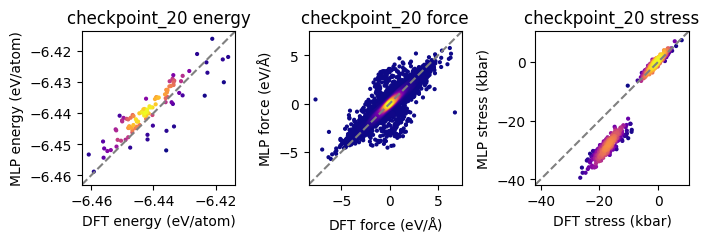

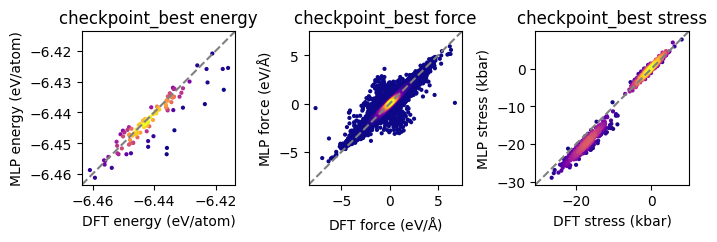

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# draw a parity plot of energy / force / stress
unit = {"energy": "eV/atom", "force": r"eV/$\rm{\AA}$", "stress": "kbar"}
def density_colored_scatter_plot(
    dft_energy,
    nnp_energy,
    dft_force,
    nnp_force,
    dft_stress,
    nnp_stress,
    title=None
):
    modes = ['energy', 'force', 'stress']
    plt.figure(figsize=(18/2.54, 6/2.54))
    for num, (x, y) in enumerate(
        zip(
            [dft_energy, dft_force, dft_stress],
            [nnp_energy, nnp_force, nnp_stress]
        )
    ):
        mode = modes[num]
        idx = (
            np.random.choice(len(x), 1000)
            if len(x) > 1000
            else list(range(len(x)))
        )
        xsam = [x[i] for i in idx]
        ysam = [y[i] for i in idx]
        xy = np.vstack([x, y])
        xysam = np.vstack([xsam, ysam])
        zsam = gaussian_kde(xysam)

        z = zsam.pdf(xy)
        idx = z.argsort()

        x = [x[i] for i in idx]
        y = [y[i] for i in idx]
        z = [z[i] for i in idx]

        ax = plt.subplot(int(f'13{num+1}'))
        plt.scatter(x, y, c=z, s=4, cmap='plasma')

        mini = min(min(x), min(y))
        maxi = max(max(x), max(y))
        ran = (maxi-mini) / 20
        plt.plot(
            [mini-ran, maxi+ran],
            [mini-ran, maxi+ran],
            color='grey',
            linestyle='dashed'
        )
        plt.xlim(mini-ran, maxi+ran)
        plt.ylim(mini-ran, maxi+ran)

        plt.xlabel(f'DFT {mode} ({unit[mode]})')
        plt.ylabel(f'MLP {mode} ({unit[mode]})')
        ax.set_aspect('equal')
        if title:
          ax.set_title(f'{title} {mode}')
    plt.tight_layout()
    plt.show()

for label in labels:
    density_colored_scatter_plot(
        dft_energy,
        mlip_energy_dct[label],
        dft_forces,
        mlip_forces_dct[label],
        dft_stress,
        mlip_stress_dct[label],
        label,
    )